In [5]:
import sys
sys.path.append('../src')

from m4_generator import M4Generator
from utils import plot_series

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers

import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

In [ ]:
EPOCHS = 10
BATCH_SIZE = 50
LOOKBACK = 100
HORIZON = 48

gen = M4Generator("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv",
                  LOOKBACK, HORIZON, BATCH_SIZE)

model = Sequential()


model.add(LSTM(200, batch_input_shape=(BATCH_SIZE, LOOKBACK, 1),  activation='tanh',
              kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))

model.add(Dense(48, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3)))

opt = optimizers.RMSprop(lr=0.001, clipvalue=0.5)

model.compile(loss='mae', optimizer=opt)

hist = model.fit_generator(gen, steps_per_epoch= gen.__len__(), epochs=EPOCHS)

Epoch 1/10
64/64 [==============================] - 11s 171ms/step - loss: 0.1577
Epoch 2/10
64/64 [==============================] - 11s 168ms/step - loss: 0.1269
Epoch 3/10
64/64 [==============================] - 11s 173ms/step - loss: 0.1118
Epoch 4/10
64/64 [==============================] - 11s 167ms/step - loss: 0.0990
Epoch 5/10
64/64 [==============================] - 11s 170ms/step - loss: 0.0914
Epoch 6/10
64/64 [==============================] - 11s 169ms/step - loss: 0.0864
Epoch 7/10
64/64 [==============================] - 11s 171ms/step - loss: 0.0807
Epoch 8/10
64/64 [==============================] - 11s 170ms/step - loss: 0.0782
Epoch 9/10
64/64 [==============================] - 11s 169ms/step - loss: 0.0777
Epoch 10/10
63/64 [============================>.] - ETA: 0s - loss: 0.0774

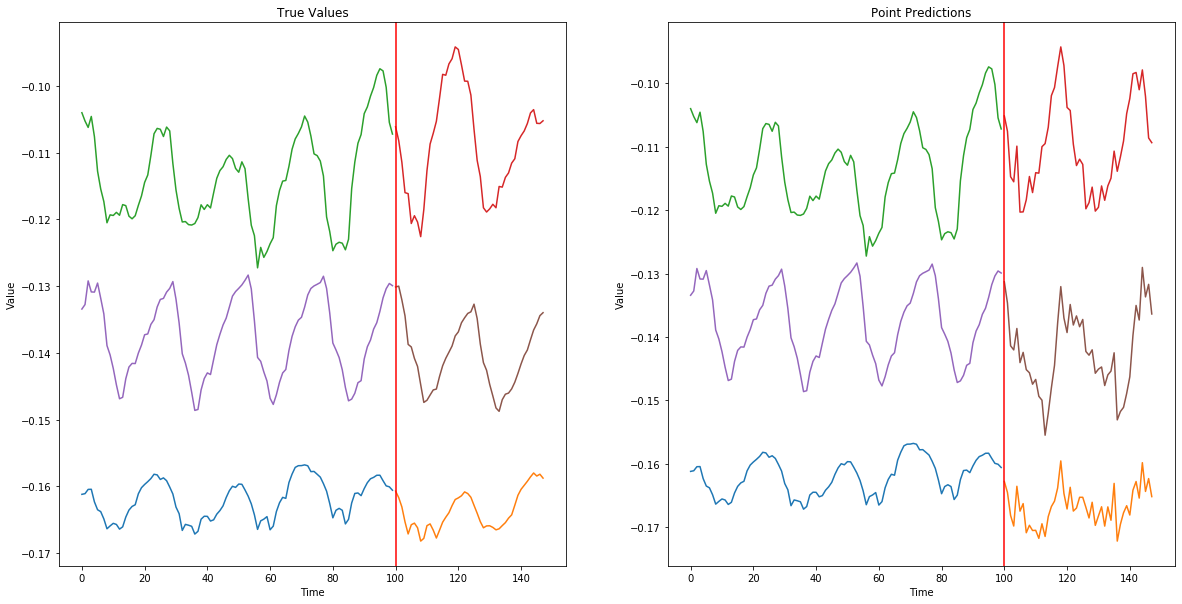

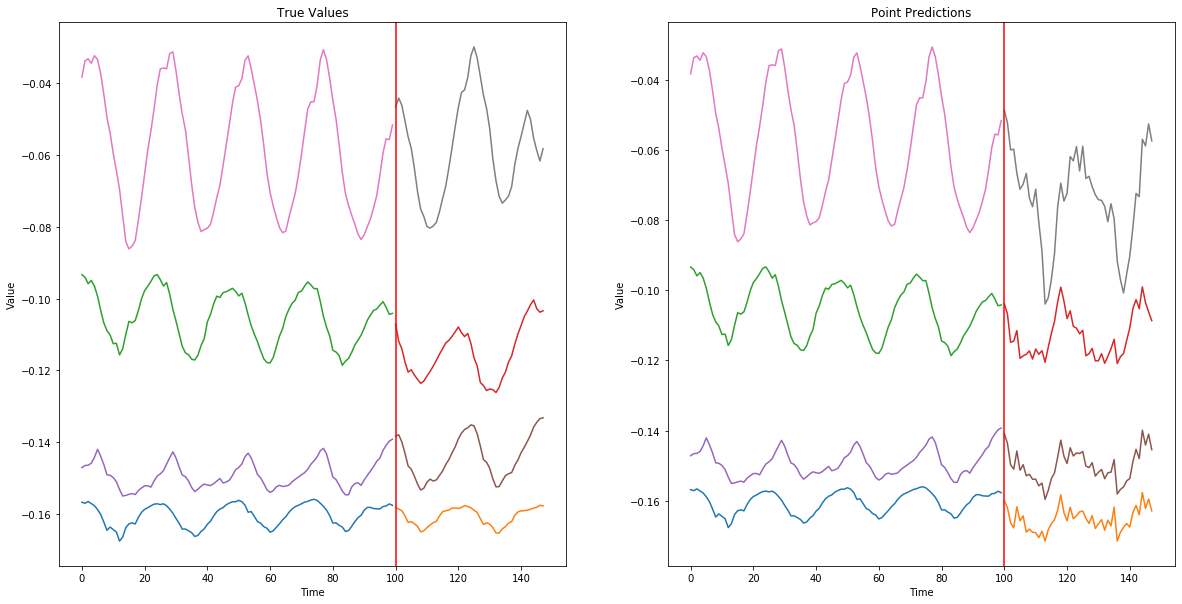

In [6]:
train_x, train_y, test_x, test_y = gen.get_data()

#============ Predict Train
predictedY = model.predict(train_x[:BATCH_SIZE,:].reshape(BATCH_SIZE, LOOKBACK, 1), batch_size = BATCH_SIZE)

plot_series(train_x, train_y, predictedY)

#============ Predict Test
predictedY = model.predict(test_x[:BATCH_SIZE,:].reshape(BATCH_SIZE, LOOKBACK, 1), batch_size = BATCH_SIZE)

plot_series(test_x, test_y, predictedY, series_num=4)